## The goal of this notebook is to use unsupervised learning techniques to identify groups of customers that are similar. This notebook will then summarize the characteristics of each group of customers, so that they can be each distinctly marketed towards. The data was taken from kaggle: https://www.kaggle.com/imakash3011/customer-personality-analysis

### Lets read the data into pandas dataframes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

categorical_columns = ["AcceptedCmp1", "AcceptedCmp2", "AcceptedCmp3", "AcceptedCmp4", "AcceptedCmp5", "Response", "Education", "Marital_Status", "Complain"]
cols = list(pd.read_csv("marketing_campaign.csv", nrows =1, delimiter="\t")) # get the column names in the csv file

#the columns that are not categorical are read into this dataframe
data_noncategorical = pd.read_csv("marketing_campaign.csv", delimiter="\t", parse_dates=["Year_Birth","Dt_Customer"], usecols=[c for c in cols if c not in categorical_columns])
data = pd.read_csv("marketing_campaign.csv", delimiter="\t", parse_dates=["Year_Birth","Dt_Customer"])

date_columns = ["Year_Birth", "Dt_Customer"]
blacklist = ["Z_Revenue", "Z_CostContact", "ID"] #these columns contain no information (i.e. always the same value) and the customer ID is not important
discrete_columns = ["Teenhome", "Kidhome"] + [el for el in data.columns if "Num" in el]

#convert the dates into floating columns
for date_column in date_columns:
    data_noncategorical[date_column] = data_noncategorical[date_column].values.astype(np.float64)
    data[date_column] = data[date_column].values.astype(np.float64)

# Each column of the pandas dataframe is summarized below

## People

ID: Customer's unique identifier  \
Year_Birth: Customer's birth year  \
Education: Customer's education level  \
Marital_Status: Customer's marital status  \
Income: Customer's yearly household income  \
Kidhome: Number of children in customer's household  \
Teenhome: Number of teenagers in customer's household  \
Dt_Customer: Date of customer's enrollment with the company  \
Recency: Number of days since customer's last purchase  \
Complain: 1 if the customer complained in the last 2 years, 0 otherwise  \
## Products
MntWines: Amount spent on wine in last 2 years  \
MntFruits: Amount spent on fruits in last 2 years  \
MntMeatProducts: Amount spent on meat in last 2 years  \
MntFishProducts: Amount spent on fish in last 2 years  \
MntSweetProducts: Amount spent on sweets in last 2 years  \
MntGoldProds: Amount spent on gold in last 2 years  \
## Promotion
NumDealsPurchases: Number of purchases made with a discount  \
AcceptedCmp1: 1 if customer accepted the offer in the 1st campaign, 0 otherwise  \
AcceptedCmp2: 1 if customer accepted the offer in the 2nd campaign, 0 otherwise  \
AcceptedCmp3: 1 if customer accepted the offer in the 3rd campaign, 0 otherwise  \
AcceptedCmp4: 1 if customer accepted the offer in the 4th campaign, 0 otherwise  \
AcceptedCmp5: 1 if customer accepted the offer in the 5th campaign, 0 otherwise  \
Response: 1 if customer accepted the offer in the last campaign, 0 otherwise  \
## Place
NumWebPurchases: Number of purchases made through the company’s website  \
NumCatalogPurchases: Number of purchases made using a catalogue  \
NumStorePurchases: Number of purchases made directly in stores  \
NumWebVisitsMonth: Number of visits to company’s website in the last month  \


## Before I start this analysis, let's get a better feel for the data by making histograms

/Library/Python/3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Library/Python/3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


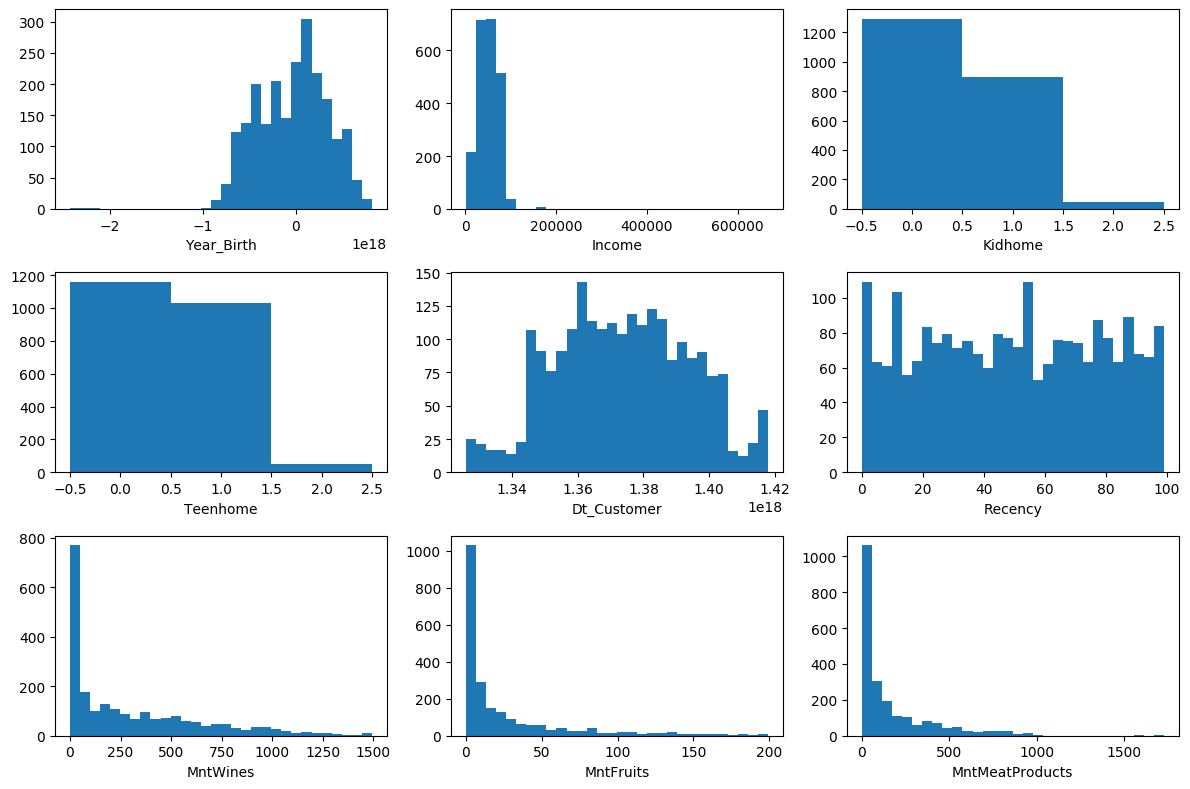

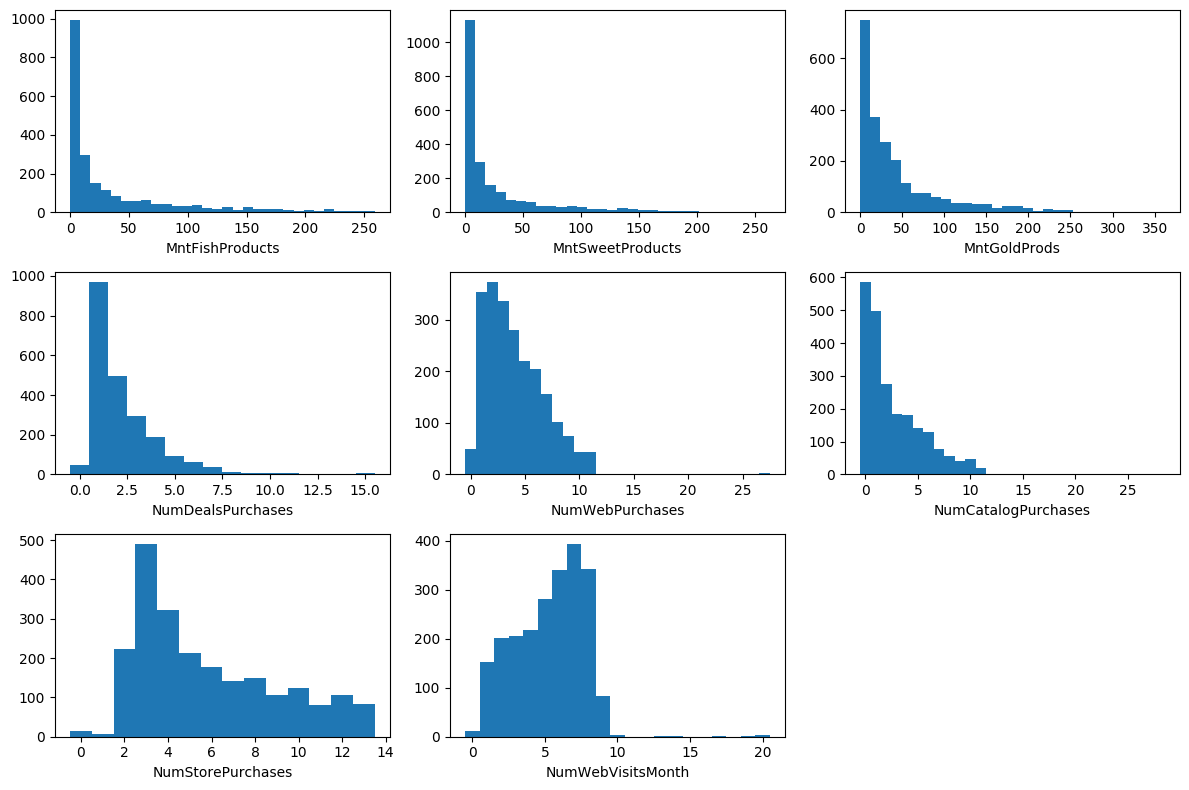

In [2]:
column_names = []
std_devs = []

def get_optimal_discrete_binning(arr):
    return  np.arange(int(min(arr)), int(max(arr)) + 2) - 0.5


def make_plots(data):
    plt_counter = 0
    for i, c in enumerate([el for el in data_noncategorical.columns if el not in blacklist]):

        plt_counter += 1
        plt.subplot(330 + plt_counter)
        if c in discrete_columns: bins = get_optimal_discrete_binning(data_noncategorical[c].values)
        else: bins = 30
        plt.hist(data_noncategorical[c].values,bins=bins)
        plt.tight_layout()
        plt.xlabel(c)
        if (i+1) % 9 == 0: 
            plt.tight_layout()
            plt.show()
            plt_counter = 0
    
    plt.show()
    
make_plots(data_noncategorical)

## Let's remove some of the outliers when making plots, so that it is easier to see and understand distributions when making plots. In the code below, I will cut away the top and bottom 0.5% of customers for each histogram.

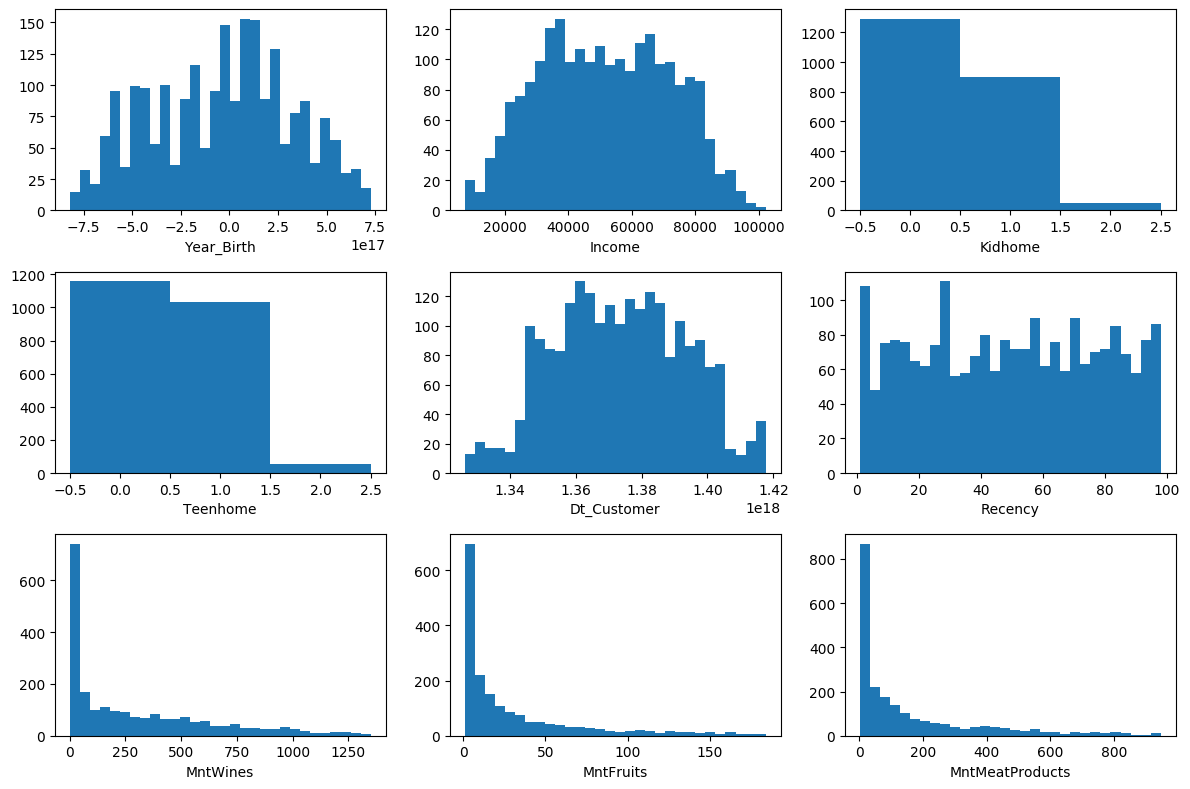

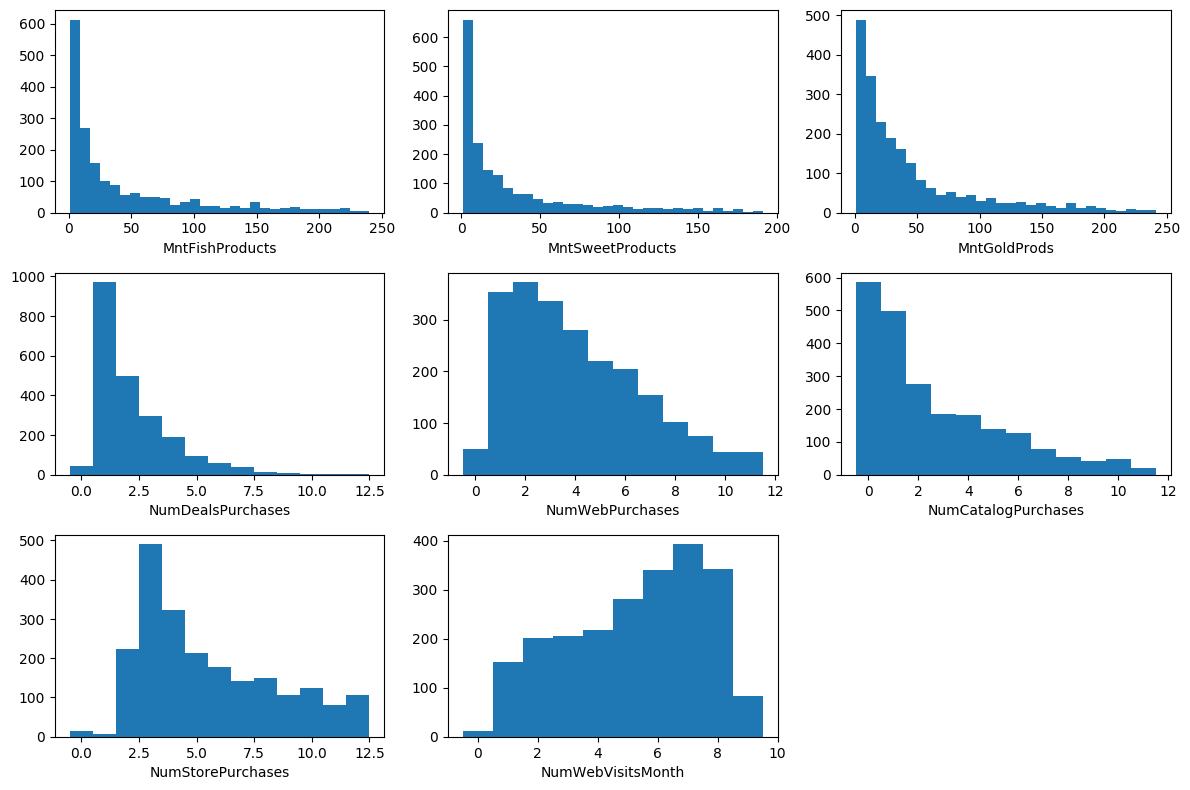

In [3]:
from sklearn.preprocessing import QuantileTransformer

def get_outlier_mask(arr, threshold_hi = 0.995, threshold_lo = 0.005):
    qt = QuantileTransformer()
    qt.fit(arr.reshape(-1,1))
    transformed = qt.transform(arr.reshape(-1, 1)).reshape(1, -1)[0]
    return (transformed > threshold_lo) & (transformed < threshold_hi)
 
#only cut the higher outliers for the cateogircal variables
only_cut_high = [el for el in data_noncategorical.columns if "home" in el or "Num" in el]

def get_thresholds(c, only_cut_high = only_cut_high):
    assert type(c) == str
    threshold_lo = -1.0
    if c not in only_cut_high:
        threshold_lo = 0.005  
    threshold_hi = 0.995
    if "home" in c: threshold_hi, threshold_lo = 10.0, -10.0
    return threshold_lo, threshold_hi

def get_clean_mask(arr):
    if not type(arr) == list: return np.logical_not(np.isnan(arr))
    else:
        masks = [get_clean_mask(el) for el in arr]
        selection = np.logical_and.reduce(masks)
        return selection
        

def clean_data(arr):
    selection = get_clean_mask(arr)
    if not type(arr) == list: return arr[selection]
    else:
        return [el[selection] for el in arr]
        
def apply_threshold(arr, c):
    if not type(arr) == list:
        assert type(c) == str
        threshold_lo, threshold_hi = get_thresholds(c)
        arr = clean_data(arr)
        mask = get_outlier_mask(arr, threshold_lo = threshold_lo, threshold_hi  = threshold_hi)
        return arr[mask]
    else:
        assert (len(arr) == len(c)) and (type(c) == list)
        total_selection = []
        for sub_arr, sub_c in zip(arr, c):
            threshold_lo, threshold_hi = get_thresholds(sub_c)
            clean_mask = get_clean_mask(sub_arr)
            outlier_mask = get_outlier_mask(sub_arr, threshold_lo = threshold_lo, threshold_hi  = threshold_hi)
            total_selection.append(clean_mask)
            total_selection.append(outlier_mask)
        total_selection = np.logical_and.reduce(total_selection)
        return [el[total_selection] for el in arr]
            

def make_plots_outlier_cut(data):
    plt_counter = 0
    for i, c in enumerate([el for el in data.columns if el not in blacklist]):

        plt_counter += 1
        plt.subplot(330 + plt_counter)

        to_plot = data[c].values
        to_plot = clean_data(to_plot)
        
        to_plot = apply_threshold(to_plot, c)
        
        if c in discrete_columns: bins = get_optimal_discrete_binning(to_plot)
        else: bins = 30
        
        plt.hist(to_plot, bins=bins)
        plt.tight_layout()
        plt.xlabel(c)
        if (i+1) % 9 == 0: 
            plt.tight_layout()
            plt.show()
            plt_counter = 0
    
    plt.show()
    
make_plots_outlier_cut(data_noncategorical)

## That's much better. Now that the outliers have been removed, let's try to identify the most important features for describing the dataset. Features that have a larger variance can be thought of as providing a better description of a given customer. The values are most different between different customers. Lets start by looking at the variances of individual variables, and then move towards

## Let's normalize all variables to be from 0.0 to 1.0 and have a look at the variances

Variable Name,Standard Deviation
Recency,0.292598
NumWebVisitsMonth,0.255103
NumCatalogPurchases,0.249388
NumStorePurchases,0.248514
MntWines,0.242411
NumWebPurchases,0.238882
Year_Birth,0.234597
MntFishProducts,0.228767
MntMeatProducts,0.223007
MntFruits,0.217391


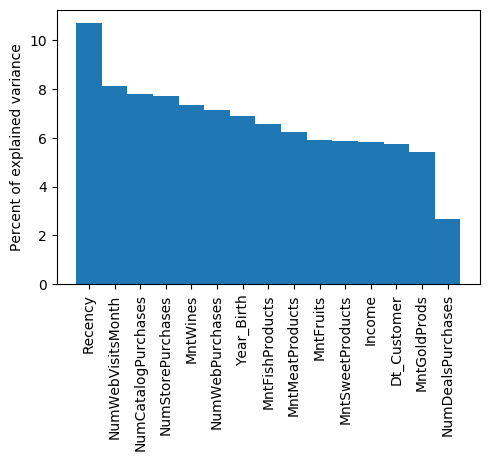

In [4]:
column_names = []
std_devs = []

for i, c in enumerate([el for el in data_noncategorical.columns if el not in blacklist]):
    if "home" in c: continue

    vals = data_noncategorical[c].values
    vals = clean_data(vals)
    vals = apply_threshold(vals, c)
    vals -= np.min(vals)
    if np.min(vals) != np.max(vals): vals = vals / np.max(vals)
        
    std_devs.append(np.std(vals))
    column_names.append(c)
    
total = sum([el**2 for el in std_devs])
    
frame = pd.DataFrame.from_dict({"Variable Name": column_names, "Standard Deviation": std_devs})
frame.sort_values(by=['Standard Deviation'], inplace=True, ascending=False)
display(HTML(frame.to_html(index=False, )))

plt.subplot(221)
plt.bar(list(frame["Variable Name"].values), list( 100.0 * (frame["Standard Deviation"].values ** 2)/total), 1.0)
plt.ylabel("Percent of explained variance")
plt.xticks(rotation=90)
plt.show()



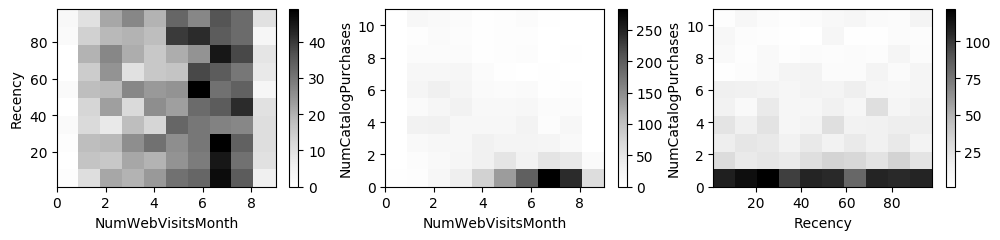

In [5]:
def make_2d_histogram(data, c1, c2):
    x = data[c1].values
    y = data[c2].values
    
    arrs = apply_threshold([x,y], [c1, c2])
    x = arrs[0]
    y = arrs[1]
    
    plt.hist2d(x, y, cmap="Greys")
    plt.xlabel(c1)
    plt.ylabel(c2)
    plt.colorbar()

    
top_three = ["NumWebVisitsMonth", "Recency", "NumCatalogPurchases"]

counter = 0
for i, el1 in enumerate(top_three):
    for el2 in top_three[i:]:
        if el1 == el2: continue
        plt.subplot(330 + counter+1)
        counter += 1
        make_2d_histogram(data_noncategorical, el1, el2)
plt.show()
    

## I'm not having much success finding groups of similar customers. Let's try identify principal components of the dataset.

## To put all variables on a more equal footing, I will apply a quantile transformation. This means that a given variable for a customer will be replaced by a number that represents their rank when compared to other customers. For example, a customer with a quantile of 0.3 in income earns more money than 30% of customers, but less money than 70% of customers. 

## I'll then perform a principal component analysis, finding the top three variables that describe the most of the variance in the dataset. Looking at the distribution of customers according to these principal components could find groups of customers that are similar.

## The principal compnents are ranked according to their variances, PC1 having the greatest.

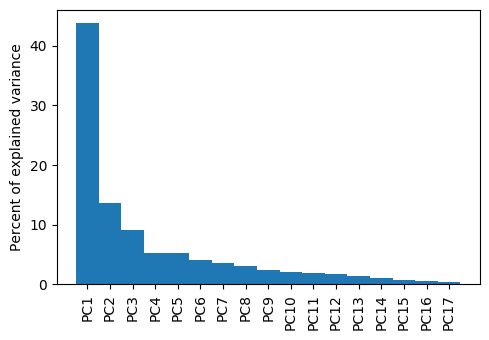

In [6]:
columns_to_use = [el for el in data_noncategorical.columns if el not in blacklist]
data_arrays = data_noncategorical[columns_to_use].values
data_arrays = data_arrays[np.logical_not(np.any(np.isnan(data_arrays), axis=1))]
from sklearn.decomposition import PCA

from sklearn.preprocessing import QuantileTransformer
def quantile_scale_array(arrays):
    qt = QuantileTransformer()
    qt.fit(arrays)
    arrays = qt.transform(arrays)
    return arrays

#mask the arrays for the outliers
#masks = []
#for i, column in enumerate(columns_to_use):
#    tlo, thi = get_thresholds(column)
#    masks.append(get_outlier_mask(data_arrays[:, i], threshold_hi = thi, threshold_lo = tlo))
#total_mask = np.logical_and.reduce(masks)
#data_arrays = data_arrays[total_mask, :]

data_arrays_scaled = quantile_scale_array(data_arrays)

pca = PCA()
pca.fit(data_arrays_scaled)

plt.subplot(221)
plt.bar( ["PC{}".format(i + 1) for i in range(0, len(pca.explained_variance_ratio_))],\
         [100.0 * el for el in pca.explained_variance_ratio_], 1.0)
plt.ylabel("Percent of explained variance")
plt.xticks(rotation=90)
plt.show()

transformed_arrays = pca.transform(data_arrays_scaled)
first_components = transformed_arrays[:,:3]

transformed_arrays_allvariables = transformed_arrays[:]
data_arrays_scaled_allvariables = data_arrays_scaled[:]
data_arrays_allvariables = data_arrays[:]
columns_to_use_allvariables = columns_to_use[:]

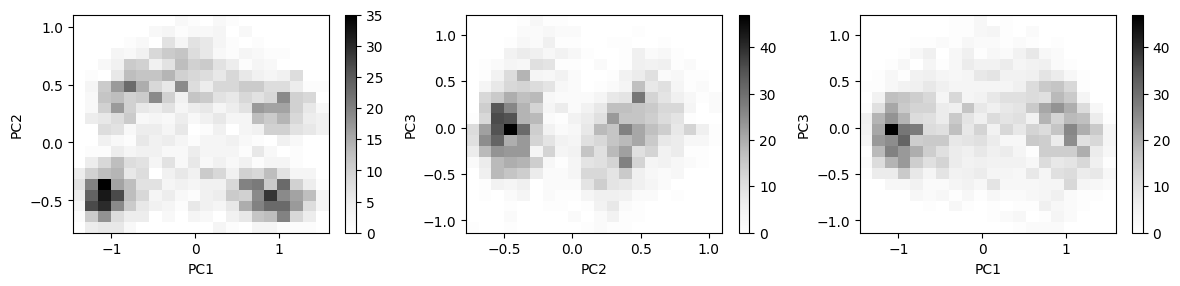

In [7]:
plt.subplot(331)
plt.hist2d(first_components[:,0], first_components[:,1], bins=[20, 20], cmap="Greys")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar()

plt.subplot(332)
plt.hist2d(first_components[:,1], first_components[:,2], bins=[20, 20], cmap="Greys")
plt.xlabel("PC2")
plt.ylabel("PC3")
plt.colorbar()

plt.subplot(333)
plt.hist2d(first_components[:,0], first_components[:,2], bins=[20, 20], cmap="Greys")
plt.xlabel("PC1")
plt.ylabel("PC3")
plt.colorbar()

plt.tight_layout()

plt.show()

## It really looks like there are four distinct categories of customers in the dataset

## Two of the variables -- Teenhome and Kidhome -- are almost binary. These two variables could create a trivial set of two classes in the dataset. What does it look like when we exclude them?

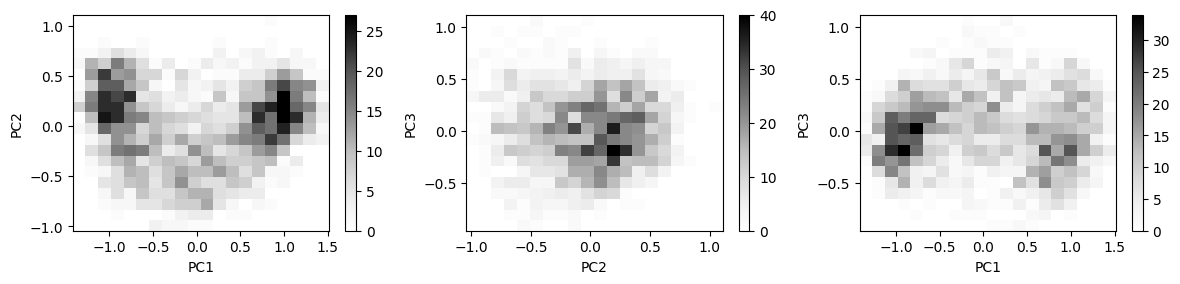

In [8]:
columns_to_use = [el for el in data_noncategorical.columns if el not in blacklist and "home" not in el]
data_arrays = data_noncategorical[columns_to_use].values
data_arrays = data_arrays[np.logical_not(np.any(np.isnan(data_arrays), axis=1))]
data_arrays_scaled = quantile_scale_array(data_arrays)

pca = PCA()
pca.fit(data_arrays_scaled)

transformed_arrays = pca.transform(data_arrays_scaled)
first_components = transformed_arrays[:,:3]

plt.subplot(331)
plt.hist2d(first_components[:,0], first_components[:,1], bins=[20, 20], cmap="Greys")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar()

plt.subplot(332)
plt.hist2d(first_components[:,1], first_components[:,2], bins=[20, 20], cmap="Greys")
plt.xlabel("PC2")
plt.ylabel("PC3")
plt.colorbar()

plt.subplot(333)
plt.hist2d(first_components[:,0], first_components[:,2], bins=[20, 20], cmap="Greys")
plt.xlabel("PC1")
plt.ylabel("PC3")
plt.colorbar()

plt.tight_layout()

plt.show()

## There are still two classes of customer in the dataset, when the binary variables such as Kidhome and Teenhome are removed. It might be worth keeping these variables in the data. People that do and do not have kids or teenagers at home are still distinct customers. Lets use k-means clustering to identify the four groups of customers, and study their properties. In the cell below, I'll run k-means clustering and verify that there are in fact four distrinct clusters of customers

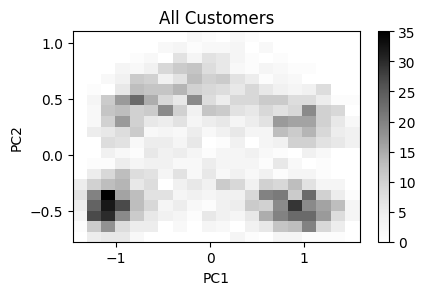

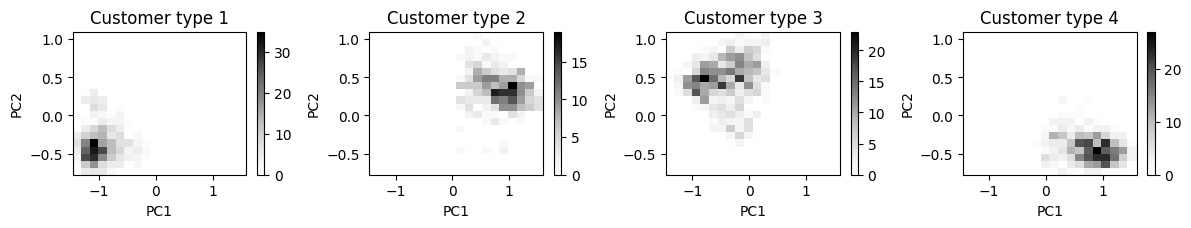

In [9]:
from sklearn.cluster import KMeans

clus = KMeans(n_clusters=4)
kmeans = clus.fit(transformed_arrays_allvariables[:,:3])
pred = clus.predict(transformed_arrays_allvariables[:,:3])


plt.subplot(331)
plt.hist2d(transformed_arrays_allvariables[:,0], transformed_arrays_allvariables[:,1], bins=[20, 20], cmap="Greys")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("All Customers")
plt.tight_layout()
plt.colorbar()
plt.show()

for c in range(0, 4):    
    plt.subplot(441 + c)
    arrs = transformed_arrays_allvariables[:, :3]
    bins_x = np.linspace(min(arrs[:, 0]), max(arrs[:, 0]), 21)
    bins_y = np.linspace(min(arrs[:, 1]), max(arrs[:, 1]), 21)
    plt.hist2d( arrs[:,0][(pred == c)], arrs[:,1][(pred == c)], bins=[bins_x, bins_y], cmap="Greys")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("Customer type {}".format(c + 1))
    plt.tight_layout()
    plt.colorbar()
plt.show()


## Now that we've identified four classes of customer, let's study their properties by looking at their average behaviour

Year_Birth
Income
Kidhome
Teenhome
Dt_Customer
Recency
MntWines
MntFruits
MntMeatProducts
MntFishProducts
MntSweetProducts
MntGoldProds
NumDealsPurchases
NumWebPurchases
NumCatalogPurchases
NumStorePurchases
NumWebVisitsMonth


/Library/Python/3.7/site-packages/ipykernel_launcher.py:71: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Library/Python/3.7/site-packages/ipykernel_launcher.py:79: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


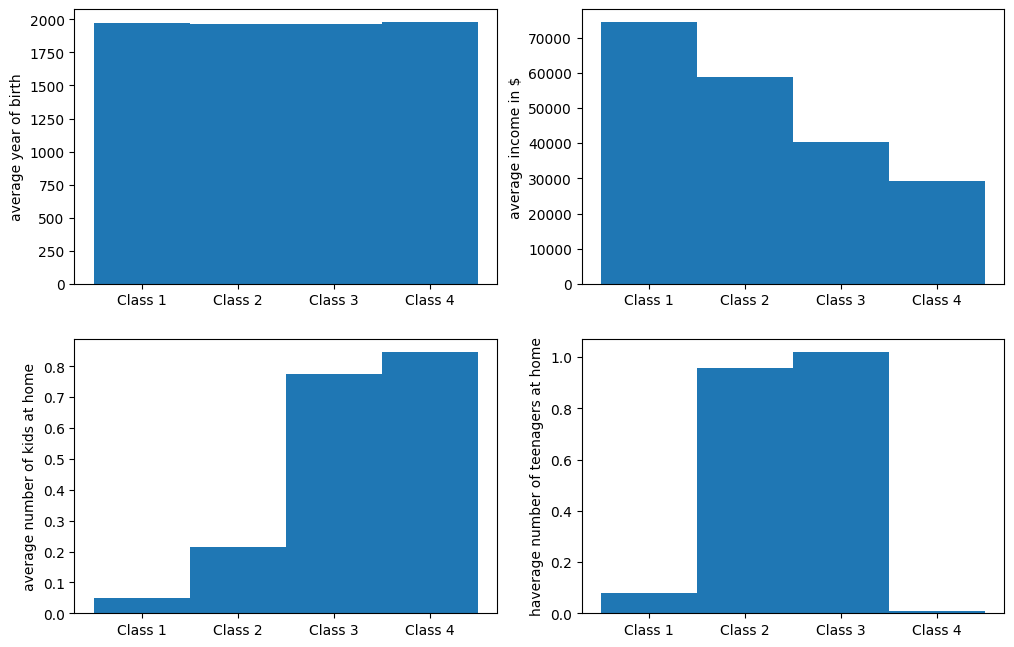

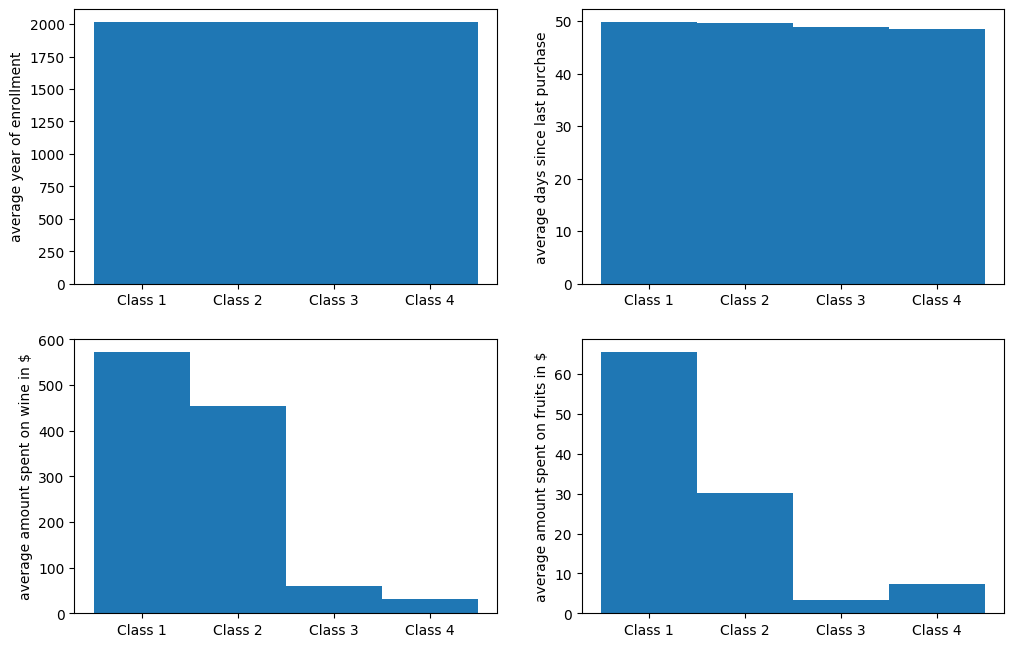

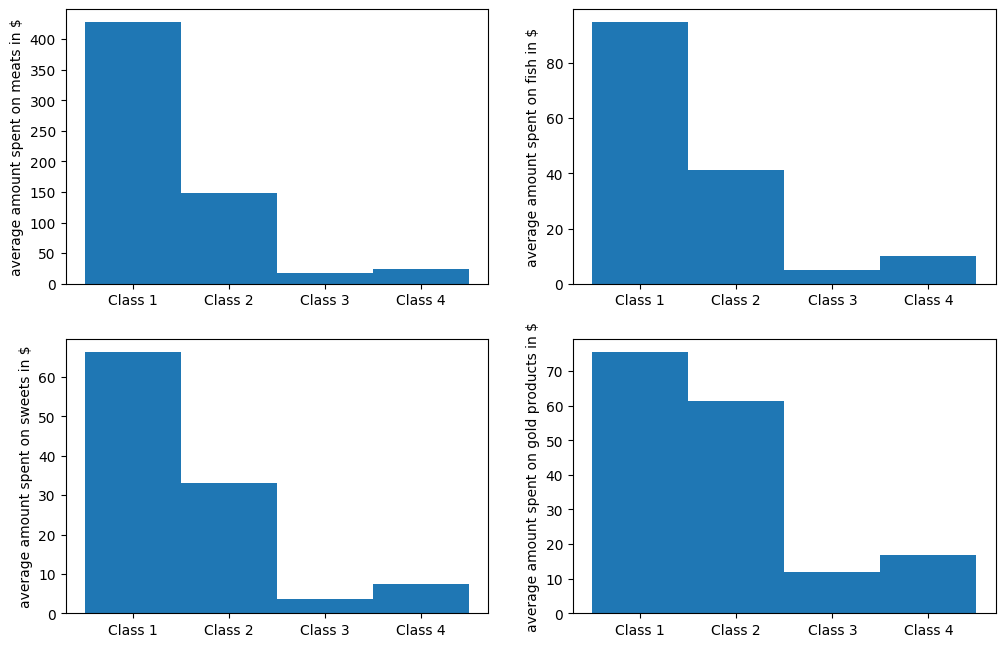

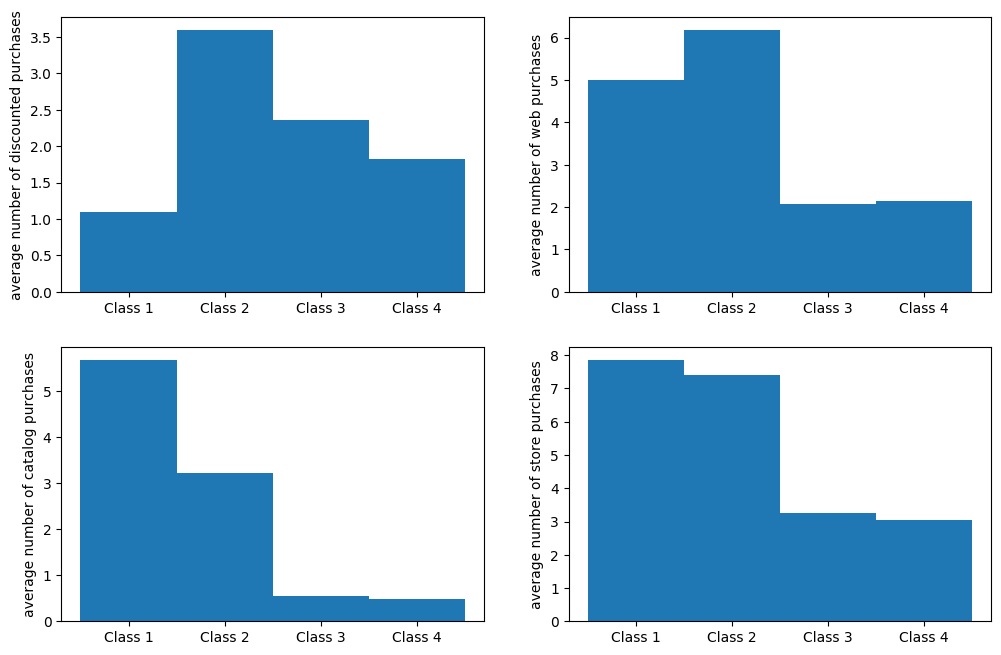

Text(0, 0.5, 'Number of customers')

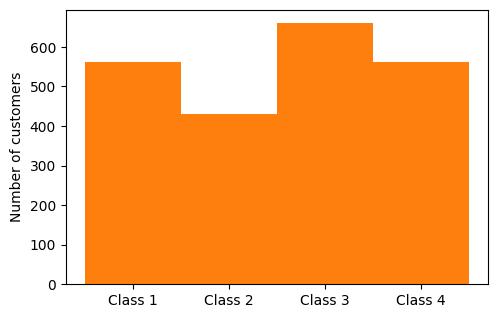

In [17]:
def get_column_index(c_name, column_names):
    for i, c in enumerate(column_names):
        if c_name == c: break
    if c_name not in column_names: raise ValueError()
    return i

def analyze_column(column_name, column_names, data_arrays, data_arrays_quantiled, pred, descriptors):
    i = get_column_index(column_name, column_names)
    thresh_lo, thresh_hi = get_thresholds(column_name, only_cut_high = only_cut_high)
    mask = get_outlier_mask(data_arrays_quantiled[:, i], threshold_hi = thresh_hi, threshold_lo = thresh_lo)
    
    averages = []
    
    for cat in [0, 1, 2, 3]:
        if not (column_name == "Year_Birth" or column_name == "Dt_Customer"): 
            average = np.average(data_arrays[:, i][mask][pred[mask] == cat])

        else: 
            average = np.array([np.average(data_arrays[:, i][mask][pred[mask] == cat])]).astype("datetime64[ns]").astype("datetime64[Y]")
            average = average[0]
        #print("class {} ".format(cat + 1) + descriptors[column_name].format(average))
        averages.append(average)
    return averages

# the first thing is to note the differences in income.
descriptors = {"Year_Birth": "was born in {}, on average",\
               "Income" : "earned ${:.0f}, on average",\
               'Kidhome' : "had {:.0f} kids, on average",\
               'Teenhome': "had {:.0f} teens, on average",\
               'Dt_Customer': "enrolled in {}, on average",\
               'Recency': "last purchased {:.0f} days ago, on average",\
               'MntWines': "spent ${:.0f} on wines, on average",\
               'MntFruits': "spent ${:.0f} on fruits, on average",\
               'MntMeatProducts': "spent ${:.0f} on meats, on average",\
               'MntFishProducts': "spent ${:.0f} on fish, on average",\
               'MntSweetProducts': "spent ${:.0f} on sweets, on average",\
               'MntGoldProds': "spent ${:.0f} on gold products, on average",\
               'NumDealsPurchases': "used {:.0f} discounts, on average",\
               'NumWebPurchases': "made {:.0f} web purchases, on average",\
               'NumCatalogPurchases': "made {:.0f} catalog purchases, on average",\
               'NumStorePurchases': "made {:.0f} store purchases, on average",\
               'NumWebVisitsMonth': "made {:.0f} web vists in the last month, on average"}

y_labels = {"Year_Birth": "average year of birth",\
            "Income" : "average income in $",\
            'Kidhome' : "average number of kids at home",\
            'Teenhome': "haverage number of teenagers at home",\
            'Dt_Customer': "average year of enrollment",\
            'Recency': "average days since last purchase",\
            'MntWines': "average amount spent on wine in $",\
            'MntFruits': "average amount spent on fruits in $",\
            'MntMeatProducts': "average amount spent on meats in $",\
            'MntFishProducts': "average amount spent on fish in $",\
            'MntSweetProducts': "average amount spent on sweets in $",\
            'MntGoldProds': "average amount spent on gold products in $",\
            'NumDealsPurchases': "average number of discounted purchases",\
            'NumWebPurchases': "average number of web purchases",\
            'NumCatalogPurchases': "average number of catalog purchases",\
            'NumStorePurchases': "average number of store purchases",\
            'NumWebVisitsMonth': "average number of web visits a month"}

to_plot = []
for column_name in columns_to_use_allvariables:
    to_plot.append(analyze_column(column_name, columns_to_use_allvariables, data_arrays_allvariables, data_arrays_scaled_allvariables, pred, descriptors))
    
    
    
x = [1, 2, 3, 4]

for i, (column_name, el) in enumerate(zip(columns_to_use_allvariables, to_plot)):
    plt.subplot(220+(i%4) + 1)
    print(column_name)
    if column_name == "Income":
        income = el
sort = np.argsort(income)[::-1]


for i, (column_name, el) in enumerate(zip(columns_to_use_allvariables, to_plot)):
    plt.subplot(220+(i%4) + 1)
    if (column_name == "Year_Birth" or column_name == "Dt_Customer"):
        el = [float(str(mip)) for mip in el]
    plt.bar(x, [el[j] for j in sort], width=1.0, tick_label = ["Class 1", "Class 2", "Class 3", "Class 4"])
    plt.ylabel(y_labels[column_name])
    if (i%4) == 3: plt.show()
    if column_name == "Income":
        income = el

#how many customers are in each class
sums = [
]
for el in x:
    sums.append(sum(1.0 * (pred==(el-1))))
    
plt.bar(x, sums,  width=1.0, tick_label = ["Class 1", "Class 2", "Class 3", "Class 4"])
plt.ylabel("Number of customers")

## To summarize, the classes of customer are defined by different levels of income:

## Average income in $:
Class 1 makes 70000  \
Class 2 makes 60000  \
Class 3 makes 40000  \
Class 4 makes 30000 

## Having kids at home:
Class 3 and 4 are very likely (>70\%) to have kids at home. Class 1 and 2 are very unlikely to: (<20\%)
Class 2 and 3 are very likely (>80\%) to have a teenager at home. Class 1 and four are very unlikely to: (10\%)

## Spending on wine, fruit, meat, etc
Customer spending on products seems to be very correlated to income, as expected. Class 1 and 2 typically spend more than class 3 and 4, in ways that are not proportional to income. e.g. even though class 1 and 2 only make 2x more money, they spend as much as 5-7x more on gold products.

## Usage of Discounts
The wealthiest class of customers used the fewest discounts, rarely using them at all. The next wealthies class used discounts the most, at around 3.5, followed by class 3 and 4.

## Interne usage:
Class 2 was the largest user of web purchases, followed closely by class 1. Classes 3 and 4 rarely make web purchases.

## Average Age
It does not appear to be the case that the different classes vary in age. They all have about the same average age.